In [1]:
%%capture

!pip install gdown contextily selenium

In [2]:
import gdown
import math
import folium
import io

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from PIL import Image
from PIL.ExifTags import TAGS, GPSTAGS

from geopy.distance import geodesic

In [3]:
%%capture

DRIVE_FOLDER = 'https://drive.google.com/drive/folders/11ZfbrfdPISxspL4sTBw0dRgqREGlEGnj?usp=sharing'
gdown.download_folder(DRIVE_FOLDER, quiet=True)

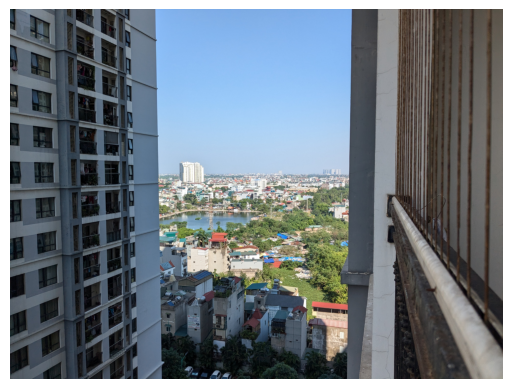

In [4]:
def show_image(path):
    img = mpimg.imread(path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

show_image('horizon/horizon.jpg')

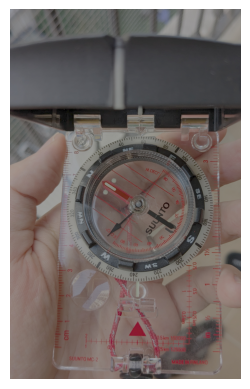

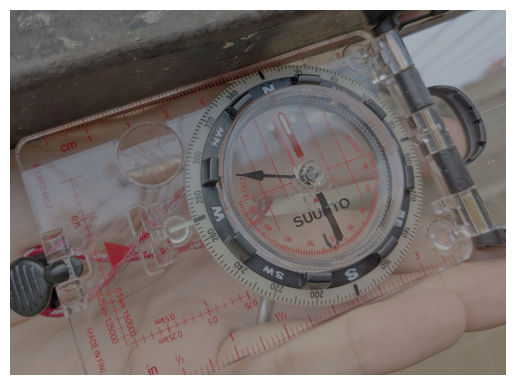

In [5]:
show_image('horizon/left_compass.jpg')
show_image('horizon/right_compass.jpg')

In [6]:
def get_gps_info(image_path):
    with Image.open(image_path) as img:
        exif_data = img._getexif()
        if not exif_data:
            return None

        exif = {
            TAGS.get(tag, tag): value
            for tag, value in exif_data.items()
            if tag in TAGS
        }

        gps_info = {}
        if 'GPSInfo' in exif:
            for idx, tag_name in GPSTAGS.items():
                tag_val = exif['GPSInfo'].get(idx)
                if tag_val:
                    gps_info[tag_name] = tag_val

        return gps_info

gps_info = get_gps_info('horizon/horizon.jpg')
gps_info

{'GPSVersionID': b'\x02\x02\x00\x00',
 'GPSLatitudeRef': 'N',
 'GPSLatitude': (20.0, 59.0, 37.14),
 'GPSLongitudeRef': 'E',
 'GPSLongitude': (105.0, 52.0, 10.21),
 'GPSAltitudeRef': b'\x00',
 'GPSAltitude': 15.4,
 'GPSTimeStamp': (6.0, 53.0, 5.0),
 'GPSImgDirectionRef': 'M',
 'GPSImgDirection': 3.0,
 'GPSDateStamp': '2024:11:01'}

In [7]:
def get_location(gps_info):
  lat = (
      gps_info.get('GPSLatitude'),
      gps_info.get('GPSLatitudeRef')
  )
  lon = (
      gps_info.get('GPSLongitude'),
      gps_info.get('GPSLongitudeRef')
  )

  lat_degrees = lat[0][0]
  lat_minutes = lat[0][1]
  lat_seconds = lat[0][2]
  lat_direction = lat[1]

  lon_degrees = lon[0][0]
  lon_minutes = lon[0][1]
  lon_seconds = lon[0][2]
  lon_direction = lon[1]

  lat_decimal = lat_degrees + lat_minutes/60 + lat_seconds/3600
  if lat_direction == 'S':
      lat_decimal = -lat_decimal

  lon_decimal = lon_degrees + lon_minutes/60 + lon_seconds/3600
  if lon_direction == 'W':
      lon_decimal = -lon_decimal

  return (
      float(lat_decimal),
      float(lon_decimal),
  )

location = get_location(gps_info)
location

(20.99365, 105.86950277777778)

In [8]:
# Harcoded based on pressure calculation
height_above_ground = 36.5

In [9]:
def distance_to_horizon(height):
    earth_radius = 6371000
    distance = math.sqrt(2 * earth_radius * height + height**2)
    return distance

distance = distance_to_horizon(height_above_ground)
distance

21565.813971422456

In [10]:
def generate_circle(center, distance, num_points=360):
    points = []

    for i in range(num_points):
        angle = i * 2 * np.pi / num_points
        bearing = np.degrees(angle)
        point = geodesic(meters=distance).destination(center, bearing)
        points.append((point.latitude, point.longitude))

    return points

def generate_curve(center, radius, start_angle, end_angle, steps=100):
    start_rad = math.radians(start_angle)
    end_rad = math.radians(end_angle)

    center_lat, center_lon = center

    points = []

    for i in range(steps):
        theta = math.radians(start_angle + (end_angle - start_angle) * i / steps)
        destination = geodesic(meters=radius).destination((center_lat, center_lon), math.degrees(theta))
        points.append((destination.latitude, destination.longitude))

    return points

def draw_horizon(location, distance):
    center = location

    m = folium.Map(location=location, zoom_start=12)

    folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Satellite',
        overlay = False,
        control = True,
    ).add_to(m)
    folium.LayerControl().add_to(m)

    circle_points = generate_circle(center, distance)
    folium.PolyLine(circle_points, color="red", weight=2.5, opacity=1).add_to(m)

    folium.CircleMarker(
      location=center,
      radius=5,
      color='red',
      fill=True,
      fill_color='red'
    ).add_to(m)

    curve_points = generate_curve(
        center,
        distance,
        58,
        90,
        steps=100
    )
    polygon_points = [
        center,
    ]
    polygon_points += curve_points
    polygon_points += [
        center,
    ]

    folium.Polygon(
        locations=polygon_points,
        color='lightblue',
        fill=True,
        fill_color='lightblue',
        fill_opacity=0.4
    ).add_to(m)

    return m

m = draw_horizon(location, distance)
m

In [11]:
img_data = m._to_png(5)
img = Image.open(io.BytesIO(img_data))
img

Output hidden; open in https://colab.research.google.com to view.